In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
from google.colab import files
uploaded = files.upload()

Saving pulsar_stars.csv to pulsar_stars (1).csv


Imports

In [0]:
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.metrics import classification_report, confusion_matrix, brier_score_loss, roc_curve, precision_recall_curve, silhouette_score, calinski_harabasz_score, davies_bouldin_score, recall_score, make_scorer, mean_squared_error
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV

Data Loading & Preprocessing

In [0]:
pulsar_data = np.loadtxt('pulsar_stars.csv', delimiter = ',', skiprows=1) 
X, y = pulsar_data[:,:-1], pulsar_data[:,-1]

In [0]:
def upsampling(X_train, y_train):
    X_minority = np.array([X_train[i] for i in range(len(X_train)) if y_train[i] == 1])
    kappa = (1.0 * len(X_minority)) / len(X_train)
    print('total training size: ', len(X_train))
    print('positive class training size: ', len(X_minority))
    repeat = int(1.0 / kappa) - 1
    upsampling = resample(X_minority, n_samples=repeat * len(X_minority))
    y_minority = np.ones(repeat * len(X_minority))
    X_train = np.concatenate((X_train, upsampling))
    print('updated positive class training size: ', len(upsampling))
    y_train = np.concatenate((y_train, y_minority))

def data_prep(X, y, normalize=False, upsample=False, train_val_test=False, train_test=False, k_fold=False, k=None):
  if normalize:
    scaler = StandardScaler().fit(X, y)
    X = scaler.transform(X)
  if train_val_test:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    if upsample:
      upsampling(X_train, y_train)
    return X_train, X_val, X_test, y_train, y_val, y_test
  if train_test:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)
    if k_fold:
      data_sets = []
      kf = KFold(n_splits=k, shuffle=True)
      for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        if upsample: 
          upsampling(X_train, y_train)
        data_sets.append((X_train, X_val, y_train, y_val))
      if upsample:
        upsampling(X, y)
      return data_sets, X, X_test, y, y_test
    else:
      if upsample: 
        upsampling(X, y)
      return X, X_test, y, y_test
  if k_fold:
    data_sets = []
    kf = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      if upsample: 
        upsampling(X_train, y_train)
      data_sets.append((X_train, X_test, y_train, y_test))
    return data_sets, X, y
  return X, y

Guassian Discriminant Analysis (Baseline)
(using scikit)

In [0]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
def gda(X_train, X_val, y_train, y_val):
  clf = QuadraticDiscriminantAnalysis()
  clf.fit(X_train, y_train)
  gda_pred = clf.predict(X_val)
  gda_pred_prob = clf.predict_proba(X_val)
  gda_score = clf.score(X_val, y_val)
  gda_train_error = mean_squared_error(y_train, clf.predict(X_train))
  gda_val_error = mean_squared_error(y_val, gda_pred)
  return gda_pred, gda_pred_prob, gda_score, gda_train_error, gda_val_error

Random Forest 
(using scikit)

In [0]:
from sklearn.ensemble import RandomForestClassifier
def rf(X_train, X_val, y_train, y_val): 
  clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, max_features=4, max_depth = 110)
  clf.fit(X_train, y_train)
  rf_pred = clf.predict(X_val)
  rf_pred_prob = clf.predict_proba(X_val)
  rf_score = clf.score(X_val, y_val)
  rf_train_error = mean_squared_error(y_train, clf.predict(X_train))
  rf_val_error = mean_squared_error(y_val, rf_pred)
  return rf_pred, rf_pred_prob, rf_score, rf_train_error, rf_val_error

Random Forest - Hyperparameter Tuning
(using scikit)

In [0]:
from sklearn.ensemble import RandomForestClassifier
def rf_hyper_param_tuning(X_train, X_test, y_train, y_test): 
  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
  # Number of features to consider at every split
  max_features = [2, 3, 4]
  # Maximum number of levels in tree
  max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [1, 2, 4]
  # Method of selecting samples for training each tree
  bootstrap = [True, False]
  # Method of measuring the quality of a split 
  criterion = ['gini', 'entropy']
  random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
  print("initializing tuning...")
  clf_random = RandomizedSearchCV(RandomForestClassifier(criterion='entropy'), random_grid, n_iter = 25, scoring = make_scorer(recall_score), cv = 4, verbose=1)
  print("beginning to optimize...")
  clf_random.fit(X_train, y_train)
  print("evaluating...")
  rf_pred = clf_random.predict(X_test)
  rf_pred_prob = clf_random.predict_proba(X_test)
  rf_score = clf_random.score(X_test, y_test)
  rf_train_error = mean_squared_error(y_train, clf_random.predict(X_train))
  rf_val_error = mean_squared_error(y_test, rf_pred)
  return rf_pred, rf_pred_prob, rf_score, clf_random.best_params_, rf_train_error, rf_val_error
  

Display & Plot Evaluation Metrics (Classification)

In [0]:
def eval_clf(clf_pred, clf_pred_prob, y_val, clf_score, alternative_treshold=None, plot=False):
  print("score: ", clf_score)
  print(classification_report(y_val, clf_pred))
  print("confusion matrix:")
  print(confusion_matrix(y_val, clf_pred))
  print("brier score loss: ", brier_score_loss(y_val, clf_pred_prob[:,1]))

  if plot:
    clf_fpr, clf_tpr, clf_thresholds = roc_curve(y_val, clf_pred_prob[:,1])
    plt.plot(clf_fpr, clf_tpr, marker='.')
    plt.title('ROC Curve')
    plt.xlabel('1 - Specifity (FPR)')
    plt.ylabel('Sensitivity (TPR)')
    plt.show()
    plt.plot(clf_thresholds, clf_tpr, marker='.', label='Sensitivity (TPR)')
    plt.plot(clf_thresholds, clf_fpr, marker='.', label='1 - Specifity (FPR)')
    plt.plot(clf_thresholds, clf_tpr - clf_fpr, marker='.', label='Difference (TPR - FPR)')
    plt.xlim([0.0, 1.0])
    plt.title('Sensitivity / 1 - Specifity / Difference vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity / 1 - Specifity / Difference')
    plt.legend()
    plt.show()

    clf_precision, clf_recall, clf_thresholds = precision_recall_curve(y_val, clf_pred_prob[:,1])
    plt.plot(clf_recall, clf_precision, marker='.')
    plt.title('PRC Curve')
    plt.xlabel('Recall (TPR)')
    plt.ylabel('Precision (PPV)')
    plt.show()

    clf_frac_pos, clf_prob_pos = calibration_curve(y_val, clf_pred_prob[:,1], n_bins=10, strategy='uniform')
    plt.plot(clf_prob_pos, clf_frac_pos, marker='.')
    plt.title('Calibration')
    plt.xlabel('Probability')
    plt.ylabel('Fraction of Positives')
    plt.show()

  if alternative_treshold:
    print("Threshold = ", alternative_treshold, ":")
    clf_new_pred = [1 * (clf_pred_sample_prob[1] > alternative_treshold) for clf_pred_sample_prob in clf_pred_prob]
    print(classification_report(y_val, clf_new_pred))
    print("confusion matrix:")
    print(confusion_matrix(y_val, clf_new_pred))

Decision Tree (Classes)

In [0]:
def counts(y):
  counts = {}
  for label in y:
    if label not in counts:
        counts.update({label:0}) 
    else:
      label_count = counts.get(label)
      label_count = label_count + 1
      counts.update({label:label_count})
  return counts

def entropy(labels):
  counts_p = counts(labels)
  probs = []
  for c in counts_p:
    probs.append(counts_p.get(c)/len(labels))
  entropy = 0
  for p in probs:
    if p > 0:
      entropy = entropy+p*np.log2(p)
  
  return -entropy

class Question:
  def __init__(self, feature, threshold, left, right, value, leaf):
     self.feature = feature
     self.threshold = threshold
     self.left = left
     self.right = right
     self.value = value
     self.leaf = leaf

class Decision_Tree:
  def __init__(self, min_split, max_depth, num_features, gini_gain):
    self.min_split = min_split
    self.max_depth = max_depth
    self.num_features = num_features
    self.gini_gain = gini_gain
    self.root = None

  def question(self, X, y, features):
    best_gain = -1
    for f in features:
      col = X[:, f]
      thresholds = np.unique(col)
      print("calculating best threshold for feature" + str(f))
      for t in thresholds:
        if self.gini_gain:
          infgain = self.information_gain(y=y, col=col, split_threshold=t)

          if infgain > best_gain:
            best_gain = infgain
            split_index = f
            split_threshold = t
    return split_threshold, split_index

  def train(self, X, y):
    self.root = self.grow(X, y)
  
  def predict(self, X):
    predictions = []
    for d in X:
      predictions.append(self.traverse(d, self.root))
    return np.array(predictions)
  
  def traverse(self, d, question):
    if question.leaf == True:
      return question.value
    elif d[question.feature] <= question.threshold:
      return self.traverse(d, question.left)
    else:
      return self.traverse(d, question.right)

  def grow(self, X, y, depth=0):
    print("growing") 
    counts_y = counts(y)
    counts_zero = 0
    counts_one = 0
    for label in y:
      if label == 1:
        counts_one = counts_one + 1
      elif label == 0:
        counts_zero = counts_zero + 1
    #if at max depth return a leaf node
    if depth >= self.max_depth or len(counts_y) == 1 or X.shape[0] < self.min_split:
      if counts_one > counts_zero:
        leaf_value = 1
      else:
        leaf_value = 0
      return Question(feature=None, threshold=None, left=None, right=None, value=leaf_value, leaf=True)

    #otherwise find the split feature and threshold
    #randomly pick the features (can pick all by just setting num_features to the most number of features)
    features = np.random.choice(X.shape[1], self.num_features, replace=False)
    split_threshold, split_feature = self.question(X, y, features)
    left_indices, right_indices = self.split(X[:, split_feature], split_threshold)
    left_q = self.grow(X[left_indices, :], y[left_indices], depth+1)
    right_q = self.grow(X[right_indices, :], y[right_indices], depth+1)

    return Question(feature=split_feature, threshold=split_threshold, left=left_q, right=right_q, value=None, leaf=False)

  def split(self, col, split_threshold):
    left = np.argwhere(col <= split_threshold).flatten()
    right = np.argwhere(col > split_threshold).flatten()
    return left, right

  def gini_impurity():
    pass

  def information_gain(self, y, col, split_threshold):
    parent = entropy(y)
    left, right = self.split(col, split_threshold)

    if len(left) == 0 or len(right) == 0:
      return 0

    l_entropy = entropy(y[left])
    r_entropy = entropy(y[right])

    child = len(left)/len(y) * l_entropy + len(right)/len(y) * r_entropy

    return parent - child

Random Forest - Scratch (Class)

In [0]:
def bootstrap(X, y):
  indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
  return(np.array(X[indices]), np.array(y[indices]))

class Random_Forest:
  def __init__(self, num_trees=100, min_split=2, max_depth=2, num_features=2, gini_gain=True, trees=[]):
    self.num_trees = num_trees
    self.num_features = num_features
    self.min_split = min_split
    self.max_depth = max_depth
    self.gini_gain = True
    self.trees = trees
  
  def fit(self, X, y):
    self.trees = []
    for x in range(self.num_trees):
      tree = Decision_Tree(min_split=self.min_split, max_depth=self.max_depth, num_features=self.num_features, gini_gain=self.gini_gain)
      bs_X, bs_y = bootstrap(X, y)
      print("training tree")
      tree.train(bs_X, bs_y)
      self.trees.append(tree)

  def predict(self, X):
    print("predicting for forest")
    preds = []
    for tree in self.trees:
      preds.append(tree.predict(X))
    preds = np.array(preds)
    preds = np.swapaxes(preds, 0, 1)
  
    final_preds = []
    for p in preds:
      pred_zero = 0
      pred_one = 0
      #calc number of zeros and ones 
      for label in p:
        if label == 1:
          pred_one = pred_one + 1
        elif label == 0:
          pred_zero = pred_zero + 1

      if pred_one > pred_zero:
        final_preds.append(1)
      else:
        final_preds.append(0)
    return np.array(final_preds)

  def predict_proba(self, X):
    preds = []
    for tree in self.trees:
      preds.append(tree.predict(X))
    preds = np.array(preds)
    preds = np.swapaxes(preds, 0, 1)
    
    final_pred_probs = []
    for p in preds:
      pred_zero = 0
      pred_one = 0
      #calc number of zeros and ones 
      for label in p:
        if label == 1:
          pred_one = pred_one + 1
        elif label == 0:
          pred_zero = pred_zero + 1
      probs = np.array([pred_zero, pred_one]) / (pred_zero + pred_one)
      final_pred_probs.append(probs)
    return np.array(final_pred_probs)

  def get_params(self, deep=True):
    params = {'num_trees': self.num_trees,
              'max_depth': self.max_depth,
              'min_split': self.min_split,
              'num_features': self.num_features}
    return params

  def set_params(self, **params):
    for param, value in params.items():
        setattr(self, param, value)
    return self

  def score(self, X, y, sample_weight=None):
    preds = self.predict(X)
    count = 0
    for i in range(len(preds)):
      if preds[i] == y[i]:
        count = count + 1
    return count/len(preds)

Random Forest - Scratch

In [0]:
def accuracy(preds, y_val):
    count = 0
    for i in range(len(preds)):
      if preds[i] == y_val[i]:
        count = count + 1
    return count/len(preds)
    
def rf_scratch(X_train, X_val, y_train, y_val):
  rf = Random_Forest(num_trees=1, max_depth=10, min_split=5, num_features=4)
  rf.fit(X_train, y_train)
  preds = rf.predict(X_val)
  pred_probs = rf.predict_proba(X_val)
  acc = accuracy(preds, y_val)
  rf_train_error = mean_squared_error(y_train, rf.predict(X_train))
  rf_val_error = mean_squared_error(y_val, preds)
  return preds, pred_probs, acc, rf_train_error, rf_val_error

Main

total training size:  11454
positive class training size:  1046
updated positive class training size:  9414
total training size:  11454
positive class training size:  1048
updated positive class training size:  9432
total training size:  11454
positive class training size:  1024
updated positive class training size:  10240
total training size:  11455
positive class training size:  1045
updated positive class training size:  9405
total training size:  11455
positive class training size:  1065
updated positive class training size:  9585
total training size:  14318
positive class training size:  1307
updated positive class training size:  11763
GDA - Upsampled - K-Fold Cross Validation:
training error:  0.03466038065304697
validation error:  0.026187150837988827
training error:  0.03352540597171294
validation error:  0.031075418994413406
training error:  0.03300157150340492
validation error:  0.03212290502793296
training error:  0.031340026189436924
validation error:  0.04016765630457562


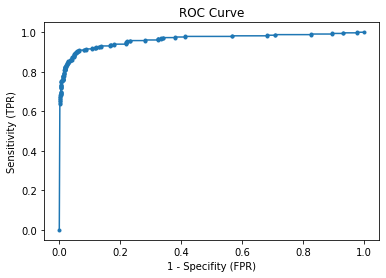

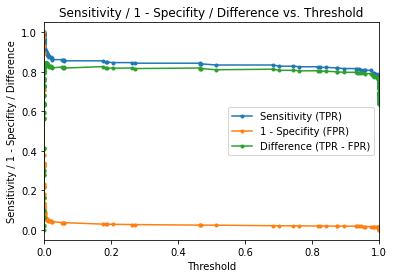

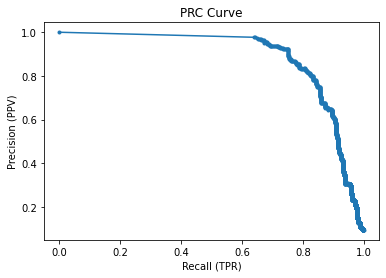

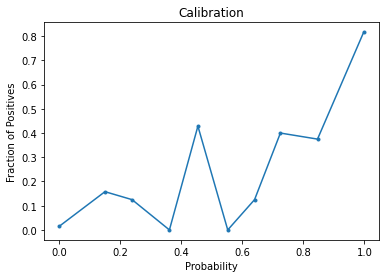

RF - Upsampled - K-Fold Cross Validation:
training error:  0.0016588091496420464
validation error:  0.017108938547486033
score:  0.9828910614525139
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2603
         1.0       0.93      0.88      0.90       261

    accuracy                           0.98      2864
   macro avg       0.96      0.94      0.95      2864
weighted avg       0.98      0.98      0.98      2864

confusion matrix:
[[2585   18]
 [  31  230]]
brier score loss:  0.014547190291338661
Threshold =  0.2 :
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      2603
         1.0       0.82      0.92      0.87       261

    accuracy                           0.97      2864
   macro avg       0.91      0.95      0.93      2864
weighted avg       0.98      0.97      0.98      2864

confusion matrix:
[[2552   51]
 [  21  240]]
training error:  0.0010476689366160294
validation

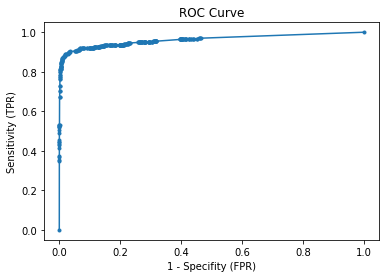

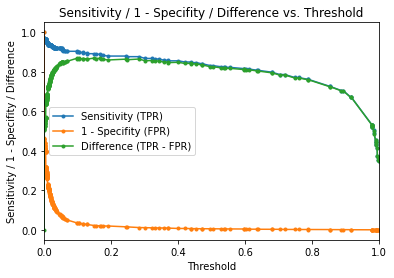

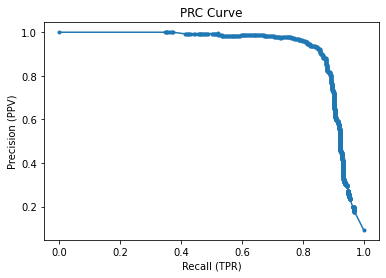

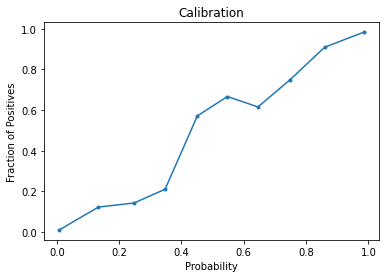

Threshold =  0.2 :
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      3248
         1.0       0.82      0.88      0.85       332

    accuracy                           0.97      3580
   macro avg       0.91      0.93      0.92      3580
weighted avg       0.97      0.97      0.97      3580

confusion matrix:
[[3185   63]
 [  40  292]]


In [0]:
# X_train, X_val, X_test, y_train, y_val, y_test = data_prep(X, y, train_val_test=True, upsample=False)

# print("GDA:")
# gda_pred, gda_pred_prob, gda_score, gda_train_error, gda_val_error = gda(X_train, X_val, y_train, y_val)
# eval_clf(gda_pred, gda_pred_prob, y_val, gda_score, alternative_treshold=0.2)

# print("RF - No Upsampling:")
# rf_pred, rf_pred_prob, rf_score, rf_train_error, rf_val_error = rf(X_train, X_val, y_train, y_val)
# print("training error: ", rf_train_error)
# print("validation error: ", rf_val_error)
# eval_clf(rf_pred, rf_pred_prob, y_val, rf_score, alternative_treshold=0.2)

# X, y = pulsar_data[:,:-1], pulsar_data[:,-1]
# X_train, X_val, X_test, y_train, y_val, y_test = data_prep(X, y, train_val_test=True, upsample=True)

# print("GDA - Upsampled:")
# gda_pred, gda_pred_prob, gda_score, gda_train_error, gda_val_error = gda(X_train, X_val, y_train, y_val)
# print("training error: ", gda_train_error)
# print("validation error: ", gda_val_error)
# eval_clf(gda_pred, gda_pred_prob, y_val, gda_score, alternative_treshold=0.2)

# print("RF - Upsampled:")
# rf_pred, rf_pred_prob, rf_score, rf_train_error, rf_val_error = rf(X_train, X_val, y_train, y_val)
# print("training error: ", rf_train_error)
# print("validation error: ", rf_val_error)
# eval_clf(rf_pred, rf_pred_prob, y_val, rf_score)

X, y = pulsar_data[:,:-1], pulsar_data[:,-1]
k_fold_data_sets, X, X_test, y, y_test = data_prep(X, y, upsample=True, train_test=True, k_fold=True, k=5)

print("GDA - Upsampled - K-Fold Cross Validation:")
ave_score = 0
ave_recall = 0
ave_train_val_diff = 0
for data_set in k_fold_data_sets:
  X_train, X_val, y_train, y_val = data_set
  gda_pred, gda_pred_prob, gda_score, gda_train_error, gda_val_error = gda(X_train, X_val, y_train, y_val)
  print("training error: ", gda_train_error)
  print("validation error: ", gda_val_error)
  # eval_clf(gda_pred, gda_pred_prob, y_val, gda_score)
  ave_score += gda_score / len(k_fold_data_sets)
  ave_recall += recall_score(y_val, gda_pred) / len(k_fold_data_sets)
  ave_train_val_diff += (gda_val_error - gda_train_error) / len(k_fold_data_sets)
print("average score: ", ave_score)
print("average recall: ", ave_recall)
print("average difference between training and validation error: ", ave_train_val_diff)

print("GDA - Upsampled - Test Set Performance:")
gda_pred, gda_pred_prob, gda_score, gda_train_error, gda_test_error = gda(X, X_test, y, y_test)
print("training error: ", gda_train_error)
print("testing error: ", gda_test_error)
print("recall: ", recall_score(y_test, gda_pred))
eval_clf(gda_pred, gda_pred_prob, y_test, gda_score, plot=True)

print("RF - Upsampled - K-Fold Cross Validation:")
ave_score = 0
ave_recall = 0
ave_train_val_diff = 0
for data_set in k_fold_data_sets:
  X_train, X_val, y_train, y_val = data_set
  rf_pred, rf_pred_prob, rf_score, rf_train_error, rf_val_error = rf(X_train, X_val, y_train, y_val)
  print("training error: ", rf_train_error)
  print("validation error: ", rf_val_error)
  eval_clf(rf_pred, rf_pred_prob, y_val, rf_score, alternative_treshold=0.2)
  ave_score += rf_score / len(k_fold_data_sets)
  ave_recall += recall_score(y_val, rf_pred) / len(k_fold_data_sets)
  ave_train_val_diff += (rf_val_error - rf_train_error) / len(k_fold_data_sets)
print("average score: ", ave_score)
print("average recall: ", ave_recall)
print("average difference between training and validation error: ", ave_train_val_diff)

print("RF - Upsampled - Test Set Performance:")
rf_pred, rf_pred_prob, rf_score, rf_train_error, rf_test_error = rf(X, X_test, y, y_test)
print("training error: ", rf_train_error)
print("testing error: ", rf_test_error)
print("recall: ", recall_score(y_test, rf_pred))
eval_clf(rf_pred, rf_pred_prob, y_test, rf_score, plot=True, alternative_treshold=0.2)

In [0]:
# print("RF - Upsampled - From Scratch:")
# rf_scratch_pred, rf_scratch_pred_prob, rf_scratch_score = rf_scratch(X_train, X_val, y_train, y_val)
# eval_clf(rf_scratch_pred, rf_scratch_pred_prob, y_val, rf_scratch_score, plot=True, alternative_treshold=0.2)

X, y = pulsar_data[:,:-1], pulsar_data[:,-1]
k_fold_data_sets, X, X_test, y, y_test = data_prep(X, y, upsample=True, train_test=True, k_fold=True, k=5)

# print("RF - Upsampled - From Scratch - K-Fold Cross Validation:")
# ave_score = 0
# ave_recall = 0
# ave_train_val_diff = 0
# for data_set in k_fold_data_sets:
#   X_train, X_val, y_train, y_val = data_set
#   rf_scratch_pred, rf_scratch_pred_prob, rf_scratch_score, rf_scratch_train_error, rf_scratch_val_error = rf_scratch(X_train, X_val, y_train, y_val)
#   print("training error: ", rf_scratch_train_error)
#   print("validation error: ", rf_scratch_val_error)
#   # eval_clf(gda_pred, gda_pred_prob, y_val, gda_score)
#   ave_score += rf_scratch_score / len(k_fold_data_sets)
#   ave_recall += recall_score(y_val, rf_scratch_pred) / len(k_fold_data_sets)
#   ave_train_val_diff += (rf_scratch_val_error - rf_scratch_train_error) / len(k_fold_data_sets)
# print("average score: ", ave_score)
# print("average recall: ", ave_recall)
# print("average difference between training and validation error: ", ave_train_val_diff)

print("RF - Upsampled - From Scratch - Test Set Performance:")
rf_scratch_pred, rf_scratch_pred_prob, rf_scratch_score, rf_scratch_train_error, rf_scratch_val_error = rf_scratch(X, X_test, y, y_test)
print("training error: ", rf_scratch_train_error)
print("testing error: ", rf_scratch_test_error)
print("recall: ", recall_score(y_test, rf_scratch_pred))
eval_clf(rf_scratch_pred, rf_scratch_pred_prob, y_test, rf_scratch_score, plot=True, alternative_treshold=0.2)

total training size:  11454
positive class training size:  1052
updated positive class training size:  9468
total training size:  11454
positive class training size:  1043
updated positive class training size:  9387
total training size:  11454
positive class training size:  1044
updated positive class training size:  9396
total training size:  11455
positive class training size:  1009
updated positive class training size:  10090
total training size:  11455
positive class training size:  1080
updated positive class training size:  9720
total training size:  14318
positive class training size:  1307
updated positive class training size:  11763
RF - Upsampled - From Scratch - Test Set Performance:
training tree
growing
calculating best threshold for feature0
calculating best threshold for feature3


total training size:  14318
positive class training size:  1306
updated positive class training size:  11754
RF - Upsampled - Hyperparameter Tuning:
initializing tuning...
beginning to optimize...
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 39.5min finished


evaluating...
training error:  0.0007682637239837967
test error:  0.021508379888268158
Hyperparameters optimized to maximize recall:  {'n_estimators': 900, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 110, 'criterion': 'gini', 'bootstrap': False}
score:  0.8618618618618619
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3247
         1.0       0.90      0.86      0.88       333

    accuracy                           0.98      3580
   macro avg       0.94      0.93      0.93      3580
weighted avg       0.98      0.98      0.98      3580

confusion matrix:
[[3216   31]
 [  46  287]]
brier score loss:  0.017432385245917344


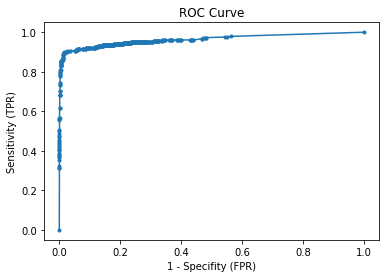

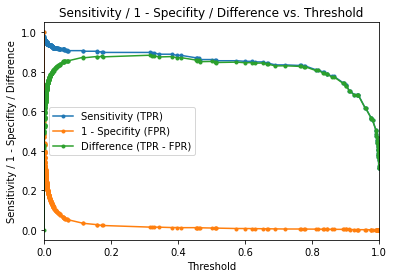

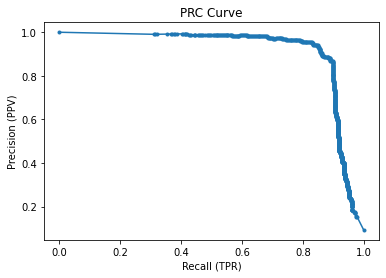

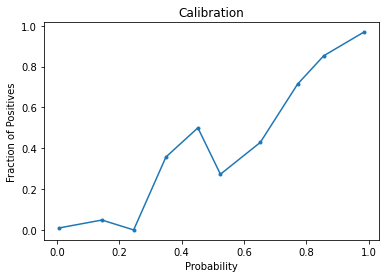

Threshold =  0.2 :
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      3247
         1.0       0.82      0.90      0.86       333

    accuracy                           0.97      3580
   macro avg       0.91      0.94      0.92      3580
weighted avg       0.97      0.97      0.97      3580

confusion matrix:
[[3183   64]
 [  34  299]]


In [0]:
X, y = pulsar_data[:,:-1], pulsar_data[:,-1]
X, X_test, y, y_test = data_prep(X, y, upsample=True, train_test=True)
print("RF - Upsampled - Hyperparameter Tuning:")
rf_pred, rf_pred_prob, rf_score, rf_best_params, rf_train_error, rf_val_error = rf_hyper_param_tuning(X, X_test, y, y_test)
print("training error: ", rf_train_error)
print("test error: ", rf_val_error)
print("Hyperparameters optimized to maximize recall: ", rf_best_params)
eval_clf(rf_pred, rf_pred_prob, y_test, rf_score, alternative_treshold=0.2)

# print("RF - Upsampled - From Scratch - Hyperparameter Tuning:")
# rf_pred, rf_pred_prob, rf_score, rf_best_params = rf_scratch_hyper_param_tuning(X, X_test, y, y_test)
# print("Hyperparameters optimized to maximize recall: ", rf_best_params)
# eval_clf(rf_pred, rf_pred_prob, y_test, rf_score, alternative_treshold=0.2)

Self-Organizing Map (Class)
OMG IT WORKKKKSSSSSS

In [0]:
import tensorflow as tf
class SOM(object):
  def __init__(self, map_dim_x, map_dim_y, input_dim, learning_rate_init, radius_init, num_iter=100):

    # Initialize properties
    self.map_dim_x = map_dim_x
    self.map_dim_y = map_dim_y
    self.input_dim = input_dim
    self.learning_rate_init = float(learning_rate_init)
    self.radius_init = float(radius_init)
    self.num_iter = num_iter

    # Initialize variables and constants:
    self.weights = tf.Variable(tf.cast(tf.random.normal([map_dim_x, map_dim_y, input_dim]), dtype=tf.float64)) # weights[i, j, k] is weight of output node [i,j] connected to input node k
    self.coords = tf.constant(np.array([np.array([np.array([i, j]) for j in range(self.map_dim_y)]) for i in range(self.map_dim_x)]))

  @tf.function
  def train_step(self, input_vect, iter_no):
    input_tensor = tf.stack([tf.stack([input_vect for j in range(self.map_dim_y)]) for i in range(self.map_dim_x)])

    # Calculate BMU
    distances_weights_to_input = self.distance_3d(self.weights, input_tensor)
    bmu = self.argmin_2d(distances_weights_to_input) # returns coord of output node [i, j]

    # Update Learning Rate and Radius for Output Nodes
    decay = tf.exp(tf.negative(tf.divide(iter_no, self.num_iter)))
    learning_rate = tf.cast(tf.multiply(self.learning_rate_init, decay), dtype=tf.float64)
    radius =  tf.cast(tf.multiply(self.radius_init, decay), dtype=tf.float64)

    bmu_tensor = tf.stack([tf.stack([bmu for j in range(self.map_dim_y)]) for i in range(self.map_dim_x)])
    distances_output_nodes_to_bmu = self.distance_3d(self.coords, bmu_tensor)
    neighborhood_influence = tf.exp(tf.negative(tf.pow(tf.divide(distances_output_nodes_to_bmu, tf.multiply(radius, 2.0)), 2.0)))

    # Update Weights
    update_coeff_tensor = tf.tile(tf.reshape(tf.multiply(learning_rate, neighborhood_influence), [self.map_dim_x, self.map_dim_y, 1]), [1, 1, self.input_dim])
    update = tf.multiply(update_coeff_tensor, tf.subtract(input_tensor, self.weights))
    new_weights = tf.add(self.weights, update)
    self.weights.assign(new_weights)
  
  def train(self, train_data):
    for iter_no in range(self.num_iter):
      for input_vect in train_data:
        self.train_step(input_vect, iter_no)
    self.centroids = self.weights

  def predict(self, train_data):
    mappings_input_to_output = []
    for input_vect in train_data:
      input_tensor = tf.stack([tf.stack([input_vect for j in range(self.map_dim_y)]) for i in range(self.map_dim_x)])
      output_node = np.array(self.argmin_2d(self.distance_3d(self.weights, input_tensor)))
      mappings_input_to_output.append(output_node)
    return mappings_input_to_output

  def get_centroid(self, i, j):
    return list(self.centroids[i][j])
  
  def distance_3d(self, tensor1, tensor2):
    return tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(tf.cast(tensor1, dtype=tf.float64), tf.cast(tensor2, dtype=tf.float64)), 2), 2))
    
  def argmin_2d(self, tensor):
    flat_tensor = tf.reshape(tensor, [self.map_dim_x * self.map_dim_y])
    argmin_flat_tensor = tf.argmin(flat_tensor, 0)
    argmin_x = argmin_flat_tensor // self.map_dim_x
    argmin_y = argmin_flat_tensor % self.map_dim_x
    return [argmin_x, argmin_y]

Self-Organizing Map

In [0]:
def som(unsup_data, output_dim_x, output_dim_y, num_iter):
  som = SOM(output_dim_x, output_dim_y, len(unsup_data[0]), 0.1, 0.1, num_iter)
  som.train(unsup_data)
  som_pred = som.predict(unsup_data)
  som_output_nodes = [[[] for _ in range(output_dim_y)] for _ in range(output_dim_x)]
  for i in range(len(som_pred)):
    x, y = som_pred[i]
    som_output_nodes[x][y].append(unsup_data[i])
  som_centroids = [[0 for _ in range(output_dim_y)] for _ in range(output_dim_x)]
  for i in range(output_dim_x):
    for j in range(output_dim_y):
      som_centroids[i][j] = []
      for component in som.get_centroid(i,j):
        som_centroids[i][j].append(float(component))
  return som_pred, som_output_nodes, som_centroids

K-Means Clustering (Baseline)
(using scikit)

In [0]:
from sklearn.cluster import KMeans
def kmeans(k, unsup_data):
  clr = KMeans(k)
  kmeans_pred = clr.fit_predict(unsup_data)
  kmeans_score = clr.score(unsup_data)
  clusters = [[] for _ in range(k)]
  for i in range(len(kmeans_pred)):
    clusters[kmeans_pred[i]].append(unsup_data[i])
  return kmeans_pred, kmeans_score, clusters, clr.cluster_centers_

Principal Component Analysis

In [0]:
from sklearn.decomposition import PCA
def pca(unsup_data, n_components):
  dcmp = PCA(n_components)
  pca_transformed_data = dcmp.fit_transform(unsup_data)
  return dcmp.components_, pca_transformed_data, dcmp.explained_variance_, dcmp

Display Evaluation Metrics (Clustering)

In [0]:
def flatten_label(label, dim):
  x, y = label
  return x * dim + y

def eval_clr(unsup_data, clr_labels, flatten=False, flatten_dim=None):
  if flatten:
    clr_labels = [flatten_label(label, flatten_dim) for label in clr_labels]
  print("Silhouette Coefficient: ", silhouette_score(unsup_data, clr_labels))
  print("Calinski-Harabasz Score (Variance Ratio Criterion): ", calinski_harabasz_score(unsup_data, clr_labels))
  print("Davies-Bouldin Score: ", davies_bouldin_score(unsup_data, clr_labels))

Main

PCA:
Principal Components:
[[ 3.17487600e-01  3.26698539e-02 -1.85687435e-02 -1.19440577e-01
  -5.76526783e-01 -2.57636797e-01  4.86816450e-02  6.94545680e-01]
 [-2.42856526e-01 -2.07159457e-05  1.39114773e-02  9.58982101e-02
   6.62986566e-01  5.77548704e-02  8.25316427e-03  6.99053492e-01]]
Explained Variance:
[3788.37666039 1550.22704621]
PCA Transformed Data:
[[ 1.65836514e+01 -3.59209476e+01]
 [ 1.97199266e+02  8.45285651e+01]
 [-3.88154561e+01  1.31302864e+01]
 ...
 [ 1.11823319e-01 -2.44553478e+01]
 [-8.62630024e+01  5.90716511e+01]
 [-6.20336817e+01  4.03953291e+01]]


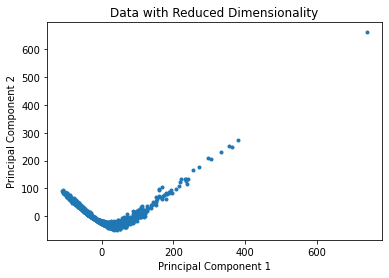

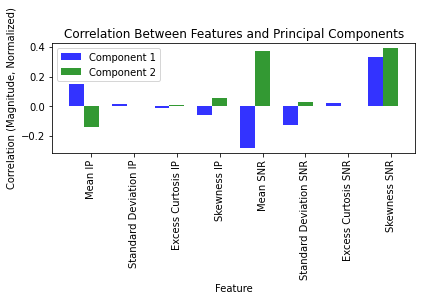

K-Means:
CLUSTER
Centroid:
[69.15822318 39.23897791  2.39446565 10.59950624 20.62712378 48.47503356
  3.71108845 18.83685832]
Count:
974
CLUSTER
Centroid:
[ 94.92737926  45.19050457   0.94048641   2.35105408   1.34641988
  12.84096791  14.45794519 255.63836522]
Count:
44
CLUSTER
Centroid:
[34.4267185  37.42274371  4.4405044  24.25917175 99.05756036 72.0981401
  0.43169994 -0.33025   ]
Count:
621


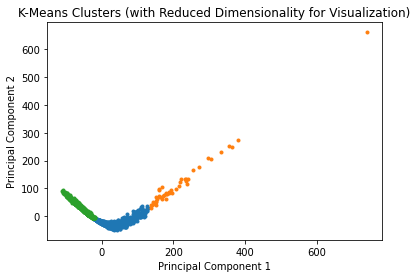

Silhouette Coefficient:  0.4413195575312856
Calinski-Harabasz Score (Variance Ratio Criterion):  1202.182899328223
Davies-Bouldin Score:  0.7672494591344196
SOM:
[[[1.974426507949829, 1.0629076957702637, 1.001844048500061, 0.6433863043785095, -1.3356983661651611, -1.5333930253982544, -0.05879317224025726, -0.9481343626976013], [-0.2730337083339691, -0.19568400084972382, -2.243474006652832, -1.7315127849578857, 0.913605809211731, -0.7535420060157776, -1.5360718965530396, -0.06435530632734299], [0.7232775092124939, -2.9415318965911865, -0.1546773910522461, 0.3356415927410126, 0.5768896341323853, 0.6537938117980957, 0.010343733243644238, -0.7353034615516663], [0.9473885893821716, 0.41961321234703064, -0.7523703575134277, 0.48287686705589294, -1.5850780010223389, 0.8467686176300049, -1.1273910999298096, -0.5640546679496765], [-1.909236192703247, -0.07895522564649582, 0.663047730922699, -0.6969704031944275, -0.11691353470087051, 0.355303019285202, 0.4222418963909149, -1.46786367893219]], [[

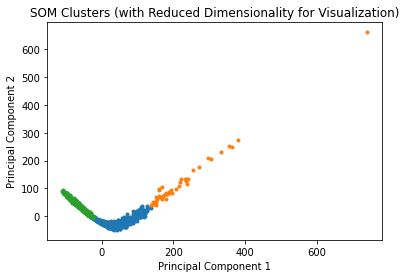

Silhouette Coefficient:  0.4418700300386931
Calinski-Harabasz Score (Variance Ratio Criterion):  1158.362010726158
Davies-Bouldin Score:  0.7543678391007752


In [0]:
X, y = pulsar_data[:,:-1], pulsar_data[:,-1]
X, y = data_prep(X, y)
unsup_data = np.array([X[i] for i in range(len(X)) if y[i] == 1])

print("PCA:")
pca_principal_components, pca_transformed_data, pca_explained_variance, pca_trained = pca(unsup_data, 2)
print("Principal Components:")
print(pca_principal_components)
print("Explained Variance:")
print(pca_explained_variance)
print("PCA Transformed Data:")
print(pca_transformed_data)
plt.scatter(pca_transformed_data[:,0], pca_transformed_data[:,1], marker='.')
plt.title('Data with Reduced Dimensionality')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#print histograms:
comp_one = pca_principal_components[0]/(np.sum(np.absolute(pca_principal_components[0])))
comp_two = pca_principal_components[1]/(np.sum(np.absolute(pca_principal_components[1])))
fig, ax = plt.subplots()
n_groups = 8
index = np.arange(n_groups)
plt.xlabel('Feature')
plt.ylabel('Correlation (Magnitude, Normalized)')
plt.title('Correlation Between Features and Principal Components')
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, comp_one, bar_width,alpha=opacity,color='b',label='Component 1')

rects2 = plt.bar(index + bar_width, comp_two, bar_width,alpha=opacity,color='g',label='Component 2')
features = ["Mean IP", "Standard Deviation IP", "Excess Curtosis IP", "Skewness IP", "Mean SNR", "Standard Deviation SNR", "Excess Curtosis SNR", "Skewness SNR"]
plt.xticks(index + bar_width, features, rotation='vertical')
plt.tight_layout()
plt.legend()
plt.show()

print("K-Means:")
kmeans_pred, kmeans_score, kmeans_clusters, kmeans_centroids = kmeans(3, unsup_data)
for i in range(len(kmeans_clusters)):
  print("CLUSTER")
  print("Centroid:")
  print(kmeans_centroids[i])
  print("Count:")
  print(len(kmeans_clusters[i]))
  pca_transformed_cluster = pca_trained.transform(kmeans_clusters[i])
  plt.scatter(pca_transformed_cluster[:,0], pca_transformed_cluster[:,1], marker='.')
plt.title('K-Means Clusters (with Reduced Dimensionality for Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
eval_clr(unsup_data, kmeans_pred)

print("SOM:")
som_pred, som_clusters, som_centroids = som(unsup_data, 5, 5, 100)
print(som_centroids)
print(np.shape(np.array(som_centroids)))
for i in range(len(som_clusters)):
  for j in range(len(som_clusters[0])):
    if len(som_clusters[i][j]) != 0:
      print("CLUSTER")
      print("Centroid:")
      print(som_centroids[i][j])
      print("Count:")
      print(len(som_clusters[i][j]))
      pca_transformed_cluster = pca_trained.transform(som_clusters[i][j])
      plt.scatter(pca_transformed_cluster[:,0], pca_transformed_cluster[:,1], marker='.')
plt.title('SOM Clusters (with Reduced Dimensionality for Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
eval_clr(unsup_data, som_pred, flatten=True, flatten_dim=5)